# Задание 1

Даны две таблицы:

* **orders** – таблица с деталями заказа, один заказ – одна строка, уникальный идентификатор заказа – order_id
* **payment_funnel_events** – таблица с событиями воронки оплаты, типы событий разделяются по полю event_type

Дан запрос, обращающийся к этим таблицам, для некоторых подзапросов приведены комментарии, объясняющие, что именно должно содержаться в запросе.

В запросе допущены ошибки и код запроса не везде оптимален, перепишите запрос и прокомментируйте ваши изменения. Комментарии и код могут не всегда соответствовать, в таком случае верить стоит комментариям и вносить правки в запрос. Если возможно несколько вариантов решения, можно выбрать любой и аргументировать свой выбор.

```
with last_error as (
  -- выбираем последнюю ошибку, которая произошла в рамках заказа (ошибки могут случаться не во всех заказах)
  select * from (
    select order_id, error_type, row_number() over(partition by order_id, user_id order by created_at asc) as rn
      from payment_funnel_events
      where event_type = 'payment_error--shown'
    ) s
  where rn = 1
),

payment_methods as (
  -- выбираем все использованные методы оплаты и время их последнего использования
  select order_id, payment_method, max(created_at) as last_changed
  from payment_funnel_events
  where event_type = 'payment_method--selected'
)


select od.order_id,
    od.payment_started, od.payment_finished,
    cast(round((unix_timestamp(payment_finished) - unix_timestamp(payment_started)) / 60, 0) as int) as payment_dur,
    coalesce(payment_page_submit, 0) payment_page_shown,
    coalesce(payment_page_submit, 0) payment_page_submit,
    coalesce(selected_card_payment, 0) selected_card_payment,
    coalesce(selected_sbp_payment, 0) selected_sbp_payment,
    coalesce(pm_max.payment_method, 'bank_card') as last_payment_method,
    error_type, od.pdate
from orders od
inner join (
    -- считаем количество показов и сабмитов страниц для каждого заказа
    select order_id,
      count(case when event_type = 'page--shown' then created_at else null end) as 'payment_page_shown',
      count(case when event_type = 'page--submit' then created_at else 0 end) as 'payment_page_submit'
    from payment_funnel_events
    where created_at > '10-01-2024'
    group by 1) pe
  on od.order_id = pe.order_id
inner join last_error le
  on od.order_id = le.order_id
left join (
  -- проверяем, какие методы оплаты были использованы и выбираем дату последней попытки оплаты
  select order_id,
    sum(case when payment_method = 'bank_card' then 1 else 0 end) as 'selected_card_payment',
    sum(case when payment_method = 'sbp' then 1 else 0 end) as 'selected_sbp_payment',
    max(last_changed) as max_last_changed
  from payment_methods
  group by 1) pm
  on od.order_id = pm.order_id
left join payment_methods pm_max
  on od.order_id = pm.order_id and pm.max_last_changed = pm_max.last_changed
where od.created_at > '01-01-2024'
```



---

# Задание 2

Загрузите файл с данными по [ссылке](https://drive.google.com/file/d/1nPQFzMncuEEmPEEEVXjWE-5hrrLiMV3z/view?usp=sharing)

Описание полей:
  * **order_id** – уникальный идентификатор заказа
  * **order_price** – цена заказа
  * **service** – услуга
  * **service_price** – цена услуги
  * **service_profit** – профит от услуги
  * **origin_country** – страна отправления
  * **destination_country** – страна прибытия
  * **order_platform** – платформа
  * **booking_depth** – глубина бронирования (период между датой бронирования и датой поездки)
  * **is_return** – если 0, то билет в одну сторону, если 1, то в обе
  * **adults** – количество взрослых в заказе
  * **children** – количество детей в заказе
  * **order_date** – дата покупки

  

**Вопросы:**

  1. При помощи Pandas соберите таблицу, где в строках будет наименование услуги, а в столбцах минимальная и максимальная цена услуги, минимальный и максимальный профит от услуги, количество заказов с услугой

  2. При помощи Pandas соберите таблицу, где в строках будет наименование услуги, а в столбцах цена и профит услуг по топ-5 странам вылета по продажам билетов.

  3. При помощи любой библиотеки визуализируйте динамику профита, оборота, доли профита от оборота по заказам с услугами. Опишите распределения и сделайте выводы.

  4. Сравните распределения цен заказов в зависимости от платформы, сделайте выводы.

  5. Проанализируйте зависимость глубины бронирования от цены и сделайте выводы.

  6. Попробуйте найти еще какие-нибудь интересные взаимосвязи между переменными в датасете, опишите их и сделайте выводы.







---

# Задание 3

Перед вами скрин одного из шагов воронки бронирования билетов на Авиасейлс. Ряд партнеров продает через нас не только сами билеты, но и сопутствующие услуги, а мы создаем для этого удобный интерфейс.

Воронка состоит из следующих шагов:
* заполнение данных пассажиров,
* выбор дополнительных услуг (возврат, обмен, страховка, уведомление),
* выбор места,
* оплата заказа.


Вопросы:
1. Какие действия пользователя на данном экране/шаге вы бы стали логировать? Какие метрики с использованием этих данных вы бы стали считать? Предположим, что вы можете собирать абсолютно любые данные, и нет никаких технических ограничений.
2. Какие из этих метрик вы считаете наиболее важными? Как их рост/снижение может сказаться на экономике продукта?
3. Какими способами можно было бы воздействовать на данные метрики, какие изменения в продукте можно сделать, чтобы их улучшить?


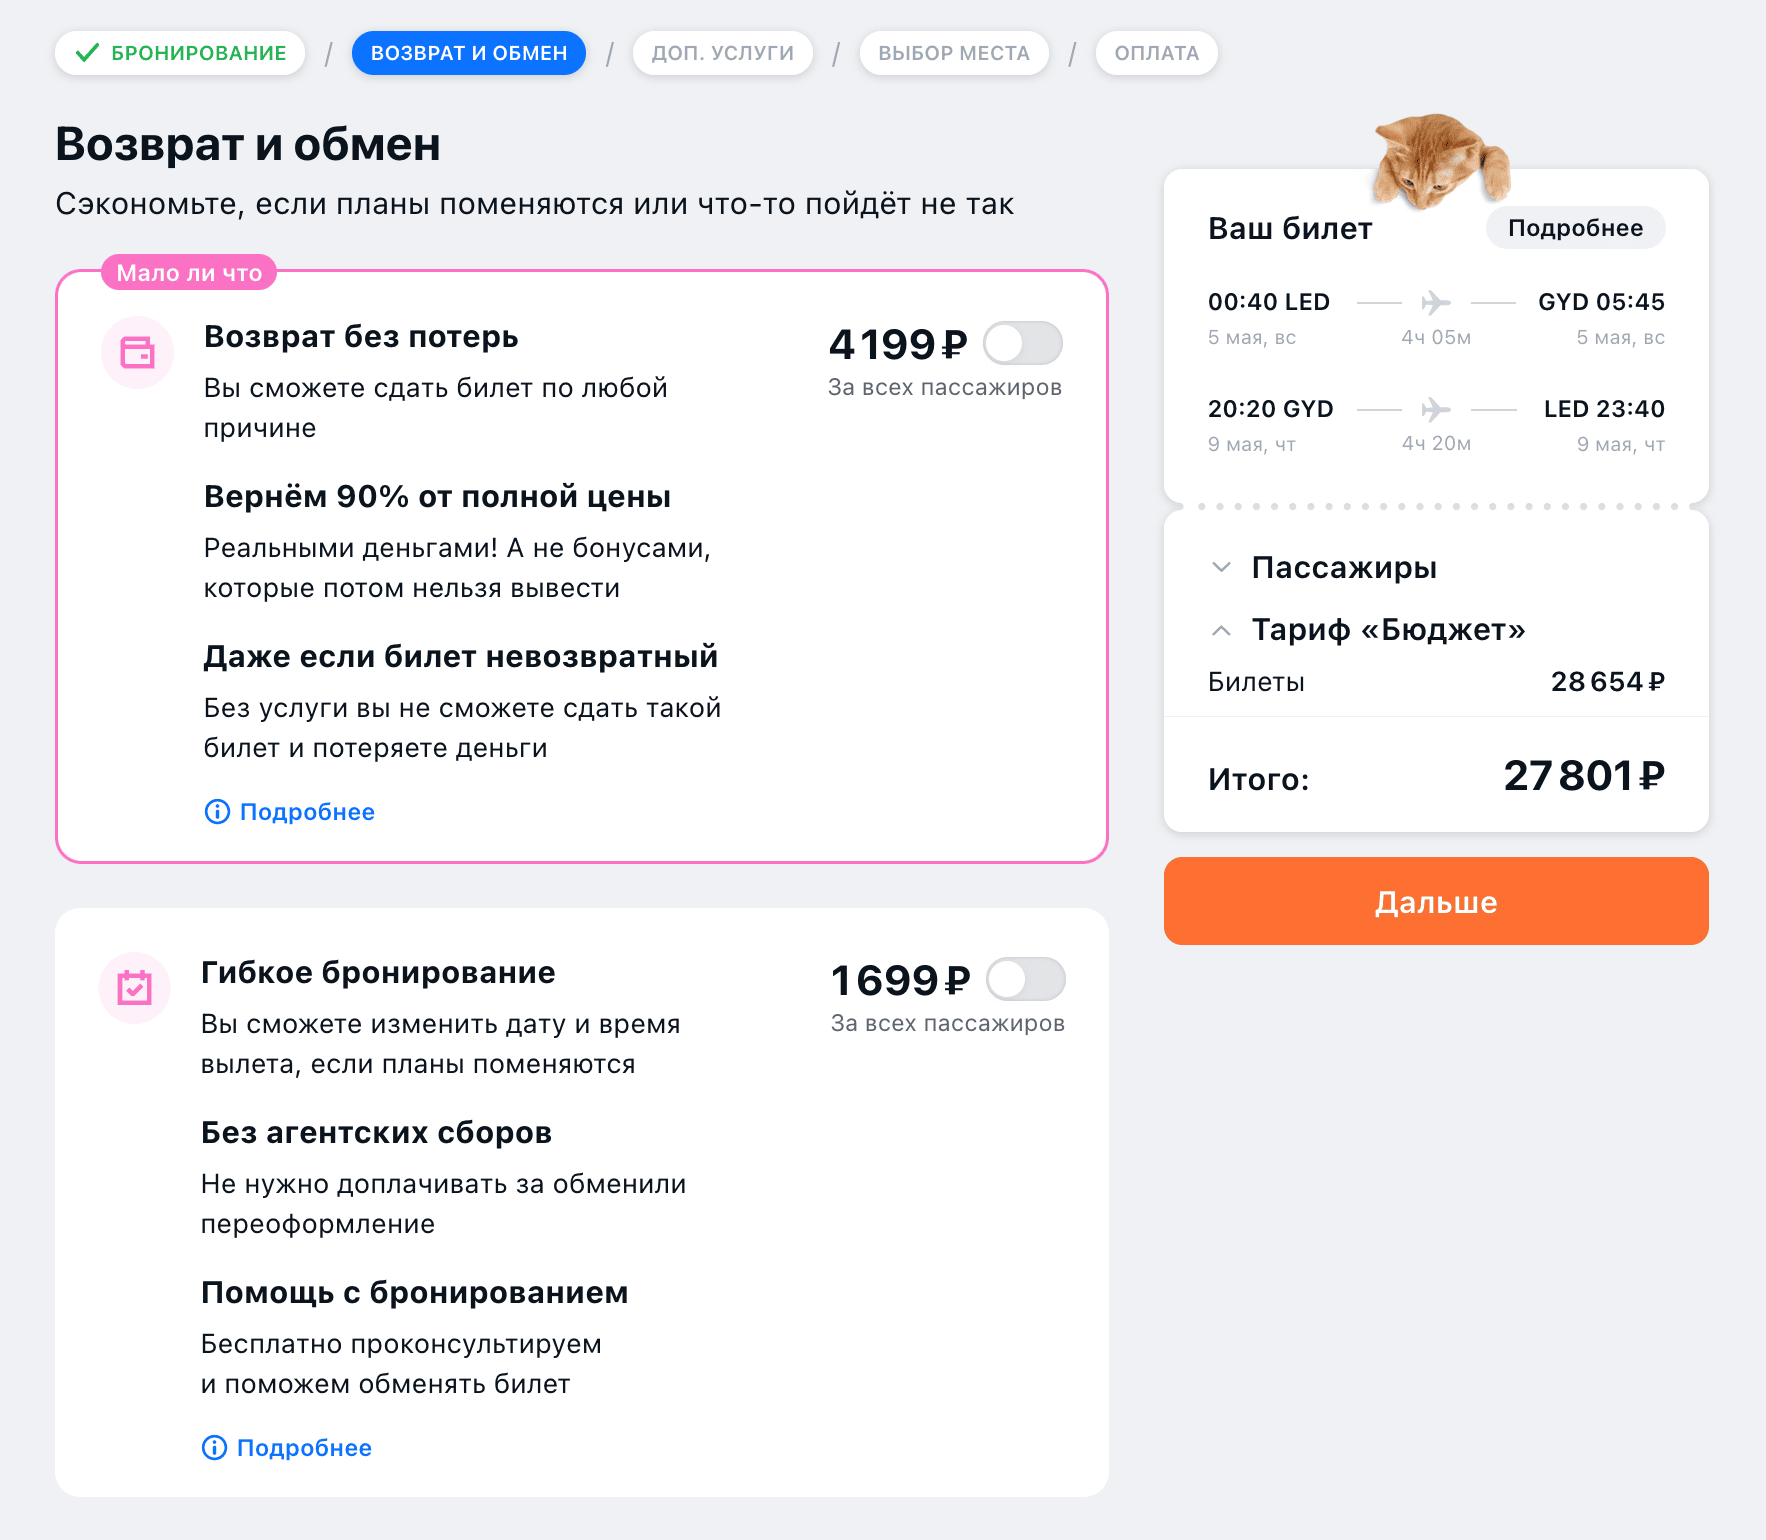
